# Streamling workflows with pipline

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                 header=None)

In [2]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:,2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.transform(['M','B'])

array([1, 0])

In [3]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=1)

/Users/xuhuahu/Library/Python/3.5/lib/python/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('sc1',StandardScaler()),('pca',PCA(n_components=2)),('clf',LogisticRegression(random_state=1))])
pipe_lr.fit(X_train,y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


## K-fold cross-validation

In [5]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train, n_folds=10, random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]),score))
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956
CV accuracy: 0.950 +/- 0.029


In [6]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10, n_jobs=1)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


## Diagnosing bias and variance problems with learning curves

/Users/xuhuahu/Library/Python/3.5/lib/python/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


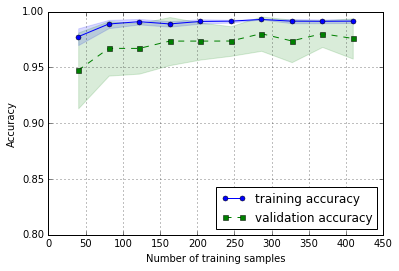

In [7]:
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
pipe_lr = Pipeline([('sc1', StandardScaler()),('clf',LogisticRegression(penalty='l2',random_state=0))])
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                        X=X_train, 
                                                        y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=10, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

## Addressing overfitting and underfitting with validation curves

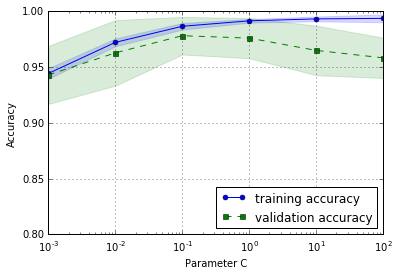

In [8]:
from sklearn.learning_curve import validation_curve
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores, = validation_curve(estimator=pipe_lr,
                                              X=X_train,
                                              y=y_train,
                                              param_name='clf__C',
                                              param_range=param_range,
                                              cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,
         label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean-train_std, alpha=0.15,
                 color='blue')
plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5,
         label='validation accuracy')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

## Tuning hyperparameter via grid search

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()),('clf',SVC(random_state=1))])
param_range = [0.001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C':param_range, 'clf__kernel':['linear']},{'clf__C':param_range, 'clf__gamma':param_range,'clf__kernel':['rbf']}]
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy',cv=10, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)

/Users/xuhuahu/Library/Python/3.5/lib/python/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.978021978021978


In [10]:
print(gs.best_params_)

{'clf__kernel': 'linear', 'clf__C': 0.1}


In [11]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.965


## Alogrithm selection with nested cross-validation

In [12]:
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.970 +/- 0.012


In [13]:
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}],
                  scoring='accuracy',
                  cv = 5)
scores = cross_val_score(gs, X_train, y_train, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.908 +/- 0.045


## Reading a confusion matrix

In [14]:
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


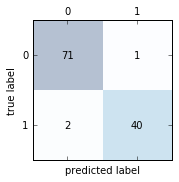

In [15]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

## Optimizing the precision and recall of a classifcation model

In [16]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976


In [17]:
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))

Recall: 0.952


In [18]:
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

F1: 0.964


In [19]:
from sklearn.metrics import make_scorer, f1_score
scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring=scorer, cv=10)

## Plotting a receiver operating characteristic

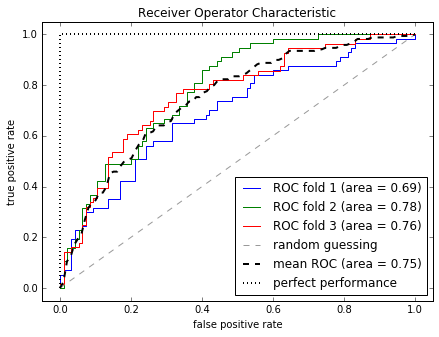

In [20]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
X_train2 = X_train[:, [4, 14]]
cv = StratifiedKFold(y_train, n_folds=3, random_state=1)
fig = plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train], y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test], probas[:,1], pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0,1],[0,1],linestyle='--', color=(0.6,0.6,0.6),label='random guessing')
mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--', label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0,0,1], [0,1,1], lw=2, linestyle=':', color='black', label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
pipe_svc = pipe_svc.fit(X_train2, y_train)
y_pred2 = pipe_svc.predict(X_test[: ,[4, 14]])
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
print(y_pred2.shape)
print('ROC AUC: %.3f' % roc_auc_score(y_true=y_test, y_score=y_pred2))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred2))

(114,)
ROC AUC: 0.671
Accuracy: 0.728
